# Text Classification - Spam Detection Фильтрация спама

Современные спам-фильтры основаны на машинном обучении. Подобные модели трудно реализовать алгоритмически. Машинное обучение рассматривает совокупность писем и использует полученные знания для классификации следующего письма. Точность таких моделей часто превышает 99%. При этом со временем они становятся все более интеллектуальными, поскольку их тренируют на вес большем количестве писем.

В одном из предыдущих примеров использовалась логистическая регрессия для предсказания того, выражает ли текст положительную или отрицательную окраску. Вероятность того, что текст выражает положительные настроения, использовалась в качестве оценки настроений, и вы видели, что такие выражения, как
"Длинные очереди и плохое клиентское обслуживание оттолкнули меня", оцениваются в баллах, близких к 0,0, а такие выражения, как "Еда была отличной, а обслуживание - превосходным", - в баллах, близких к 1,0. Теперь построим бинарную модель классификации, которая классифицирует письма как спам или не-спам, и с помощью метода [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) построим модель.

## Загрузка и подготовка данных

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models only deal with numbers, we'll use Scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to vectorize the text in the training e-mails. Then we'll split the data into training and testing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


Check for duplicate rows in the dataset.

In [2]:
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        500    499   paso firm capacity award memorandumlouise del...    2
1        500    500  take the reinsbecomeyour employer substantial ...    1

The dataset contains one duplicate row. Let's remove it and check for balance.

In [3]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  key issues going forwarda year end reviews rep...    1
1        500    500  take the reinsbecomeyour employer substantial ...    1

Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize the text in the DataFrame's "Text" column using Scikit's built-in dictionary of English stop words.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
x = vectorizer.fit_transform(df['Text'])
y = df['IsSpam']

Split the dataset so that 80% can be used for training and 20% for testing.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)  

## Train a Naive Bayes classifier

The next step is to train a Naive Bayes classifier. We'll use scikit-learn's [MultinomialDB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier, which is ideal for datasets vectorized by `CountVectorizer`.

In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

Validate the trained model with the 20% of the dataset aside for testing and show a confusion matrix.

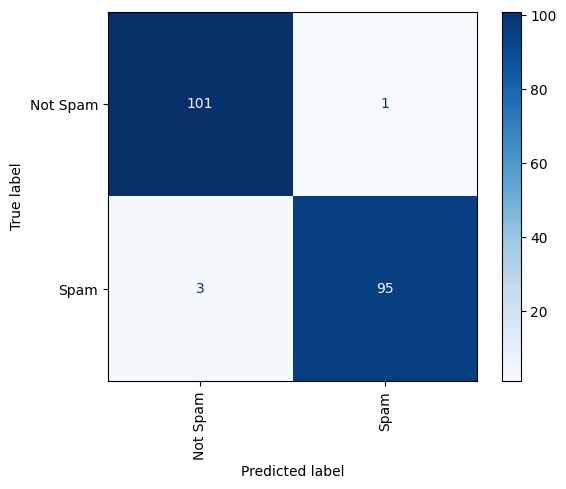

In [8]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, x_test, y_test,
                   display_labels=['Not Spam', 'Spam'],
                   cmap='Blues', xticks_rotation='vertical')

The model correctly identified 101 of 102 legitimate e-mails as not spam, and 95 of 98 spam e-mails as spam. Use the `score` method to get a rough measure of the model's accuracy.

In [9]:
model.score(x_test, y_test)

0.98

Use Scikit’s [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) class to visualize the ROC curve.

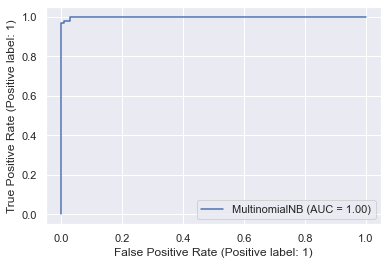

In [9]:
from sklearn.metrics import RocCurveDisplay as rcd
import seaborn as sns
sns.set()

rcd.from_estimator(model, x_test, y_test)

После обучения всего на 999 образцах площадь под RОС-кривой (AUC) показывает, что модель более чем на 99,9% точно классифицирует письма как спам или не-спам 

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts a class: 0 for not spam, or 1 for spam.

In [10]:
msg = 'Can you attend a code review on Tuesday to make sure the logic is solid?'
input = vectorizer.transform([msg])
model.predict(input)[0]

0

What is the probability that the message is not spam? We can get that by calling `predict_proba`, which returns an array containing two values: the probability that the predicted class is 0, and the probability that the predicted class is 1, in that order.

In [11]:
model.predict_proba(input)[0][0]

0.9999497111473539

Now test the model with a spam message.

In [12]:
msg = 'Why pay more for expensive meds when you can order them online and save $$$?'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

What is the probability that the message is not spam?

In [13]:
model.predict_proba(input)[0][0]

0.00021423891260677753

What is the probability that the message IS spam?

In [14]:
model.predict_proba(input)[0][1]

0.9997857610873945

Обратите внимание, что методы `predict` и `predict_proba` принимают массив входных данных. Исходя из этого, можно ли классифицировать целую партию писем одним вызовом любого из методов? Как бы вы получили результаты для каждого письма?